<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/M%26DL2501-Math%26DeepLearning/Bloque01/DL_Semana1_ChurnRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First open: Thu 4 Dec 2025

#Telco Customer Churn

**Context**
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The raw data contains 7043 rows (customers) and 21 columns (features).

The “Churn” column is our target.

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [2]:
#Versión de Tensor Flow
tf.__version__

'2.19.0'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


# 1. Cargar datos

[Link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data?select=WA_Fn-UseC_-Telco-Customer-Churn.csv)

In [6]:
DATA_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

In [19]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


# 2. EDA básico

In [7]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())
print(df["Churn"].value_counts())

(7043, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod

# 3. Preprocesamiento

In [8]:
# (a) Borrardo de variables irrelevantes
df = df.drop(columns=["customerID"])

In [13]:
# (b) Convertir total charges a numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [14]:
# (c) Definir target and predictores
target_col = "Churn"
y = (df[target_col] == "Yes").astype(int).values  # binary 0/1

# Separar features
X = df.drop(columns=[target_col])

# Identificar variables numericas vs categoricas
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_features = [c for c in X.columns if c not in num_features]

In [15]:
num_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [16]:
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [17]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


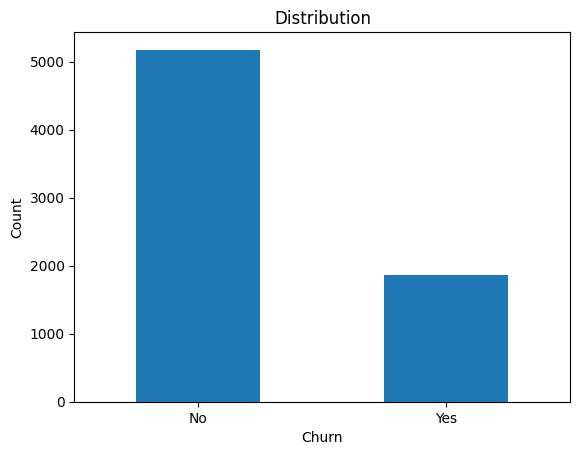

In [20]:
counts = df['Churn'].value_counts()
counts.plot.bar(rot=0) # rot=0 prevents x-axis labels from rotating
plt.title('Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 4. Construir pipeline de preprocessing

In [21]:
# Imputación de missing values
num_imputer = SimpleImputer(strategy="median")
# Para categorías, rellenamos los valores faltantes con un valor especial.
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")

In [22]:
# Encoders / scalers
num_scaler = StandardScaler()
# OneHotEncoder
cat_encoder = OneHotEncoder(handle_unknown="ignore")

In [23]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_imputer), ("scaler", num_scaler)]), num_features),
        ("cat", Pipeline([("imputer", cat_imputer), ("ohe", cat_encoder)]), cat_features),
    ],
    remainder="drop",  # drop any other columns
)

# 5. Train / validation / test split

In [24]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

In [30]:
print("Número de registros X_train_full:", len(X_train_full))
print("Número de registros y_train_full:", len(y_train_full))

print("Número de registros X_test:", len(X_test))
print("Número de registros y_test:", len(y_test))

print("Número de registros X_train:", len(X_train))
print("Número de registros y_train:", len(y_train))
print("Número de registros X_val:", len(X_val))
print("Número de registros y_val:", len(y_val))

Número de registros X_train_full: 5986
Número de registros y_train_full: 5986
Número de registros X_test: 1057
Número de registros y_test: 1057
Número de registros X_train: 5088
Número de registros y_train: 5088
Número de registros X_val: 898
Número de registros y_val: 898


train_full = train + validation -> Entrenar modelo + Ajustar Hiperparámetros

* Trainning -> 85% del Train Full(85%) = 72.2%

* Validation -> 15% del Train Full(85%) = 12.75%

* Test -> 15%

In [34]:
# Ajustar preprocessing en el conjunto training
preprocessor.fit(X_train)

# Transformamos
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

input_dim = X_train_prep.shape[1]

In [35]:
print(input_dim)

46


In [38]:
X_train.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3001,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80
2865,Female,0,Yes,Yes,66,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),109.25,7082.50
2715,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45


In [39]:
X_train_prep

array([[-0.94602562, -1.46039961, -0.92300791, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.36416254,  1.4766843 ,  2.11694176, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35092212, -1.30007482, -0.564132  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.60734024, -1.32321448, -0.23186396, ...,  0.        ,
         1.        ,  0.        ],
       [-1.27026256, -1.33478431, -0.99243508, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.20204407, -1.50006759, -0.50809687, ...,  1.        ,
         0.        ,  0.        ]])

| Conjunto       | Para qué sirve                                | Qué se hace     | Qué NO se hace |
| -------------- | --------------------------------------------- | --------------- | -------------- |
| **Training**   | Entrenar y ajustar preprocesador              | fit + transform | —              |
| **Validation** | Ajustar hiperparámetros, prevenir overfitting | transform       | fit            |
| **Test**       | Medir rendimiento final                       | transform       | fit            |


🔍 ¿Por qué es importante NO hacer fit con validation o test?

Si ajustaras el preprocesador con datos de validación o prueba:

Estarías dejando que el modelo “vea” algo de información futura.

Esto provoca fugas de datos (data leakage).

Y métricas demasiado optimistas, que NO representarán el rendimiento real.

In [32]:
X_train_prep.shape

(5088, 46)

# 6. Definimos nuestro modelo NN

In [33]:
def make_model(input_dim, dropout_rate=0.3, hidden_units=[64, 32]):
    inputs = layers.Input(shape=(input_dim,))
    x = inputs

    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

model = make_model(input_dim=input_dim, dropout_rate=0.3, hidden_units=[64, 64, 32,])

f1_metric(y_true, y_pred) function: This is a custom metric function designed to calculate the F1-score, which is particularly useful for binary classification problems, especially when the classes are imbalanced (as seen with your 'Churn' distribution).

In [40]:
def f1_metric(y_true, y_pred):
    """Compute F1 for binary classification as a custom metric."""
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), "int32")
    y_true_int = K.cast(y_true, "int32")
    tp = K.sum(K.cast(y_true_int * y_pred_bin, "float32"))
    fp = K.sum(K.cast((1 - y_true_int) * y_pred_bin, "float32"))
    fn = K.sum(K.cast(y_true_int * (1 - y_pred_bin), "float32"))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[f1_metric]
)


Acuerdate que compilar un modelo es prepararlo para el entrenamiento

In [42]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,281 (36.25 KB)

 Trainable params: 9,281 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

This diagram visually represents your neural network. Each box is a layer, showing its name, type, and output shape.

*   **Input Layer**: Where your 46 preprocessed features enter.
*   **Dense Layers**: These are your fully connected hidden layers (64, 64, then 32 neurons).
*   **Dropout Layers**: Regularization layers to prevent overfitting.
*   **Output Layer**: The final `Dense` layer with 1 neuron and `sigmoid` activation for binary classification.

The arrows show the flow of data through the network from input to output.

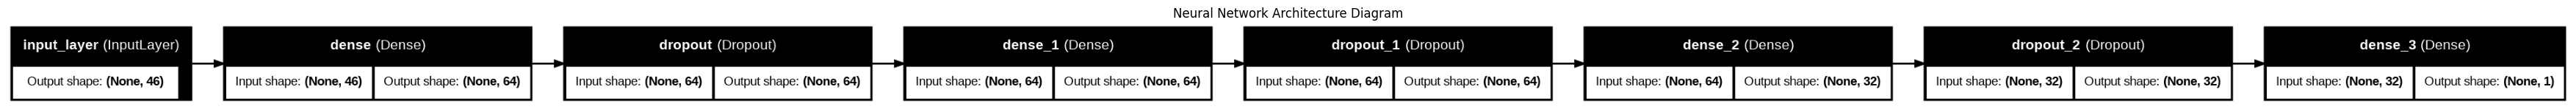

In [46]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the plot of the model architecture
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR', # 'TB' for top-down, 'LR' for left-to-right
    expand_nested=True,
    dpi=96
)

# Display the image in the notebook
img = plt.imread('model_architecture.png')
plt.figure(figsize=(45, 30)) # Increased figure size
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title('Neural Network Architecture Diagram')
plt.show()

# 7. Entrenamiento

In [47]:
early_stop = callbacks.EarlyStopping(
    monitor="val_f1_metric", mode="max", patience=10, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_f1_metric", mode="max", factor=0.5, patience=3
)

history = model.fit(
    X_train_prep,
    y_train,
    validation_data=(X_val_prep, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100
159/159 - 5s - 34ms/step - f1_metric: 0.1387 - loss: 0.5002 - val_f1_metric: 0.2351 - val_loss: 0.4474 - learning_rate: 1.0000e-03
Epoch 2/100
159/159 - 0s - 3ms/step - f1_metric: 0.2238 - loss: 0.4489 - val_f1_metric: 0.2526 - val_loss: 0.4388 - learning_rate: 1.0000e-03
Epoch 3/100
159/159 - 0s - 3ms/step - f1_metric: 0.2293 - loss: 0.4375 - val_f1_metric: 0.2403 - val_loss: 0.4351 - learning_rate: 1.0000e-03
Epoch 4/100
159/159 - 0s - 3ms/step - f1_metric: 0.2283 - loss: 0.4365 - val_f1_metric: 0.2253 - val_loss: 0.4308 - learning_rate: 1.0000e-03
Epoch 5/100
159/159 - 0s - 3ms/step - f1_metric: 0.2185 - loss: 0.4310 - val_f1_metric: 0.2246 - val_loss: 0.4346 - learning_rate: 1.0000e-03
Epoch 6/100
159/159 - 0s - 3ms/step - f1_metric: 0.2287 - loss: 0.4263 - val_f1_metric: 0.2291 - val_loss: 0.4307 - learning_rate: 5.0000e-04
Epoch 7/100
159/159 - 0s - 3ms/step - f1_metric: 0.2238 - loss: 0.4206 - val_f1_metric: 0.2233 - val_loss: 0.4285 - learning_rate: 5.0000e-04
Epoch

# 8. Evaluación sobre test

In [48]:
y_test_pred_prob = model.predict(X_test_prep).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print("Test F1:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test F1: 0.6203389830508474
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       777
           1       0.59      0.65      0.62       280

    accuracy                           0.79      1057
   macro avg       0.73      0.75      0.74      1057
weighted avg       0.80      0.79      0.79      1057

Confusion matrix:
 [[650 127]
 [ 97 183]]


### Plotting Training History (Loss and F1-score)

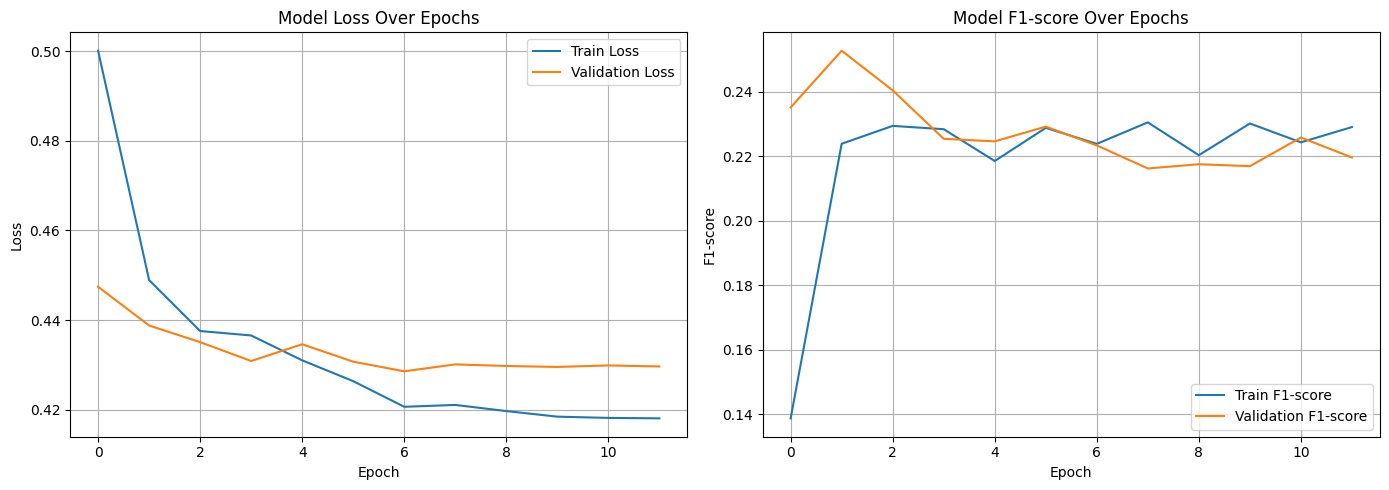

In [51]:
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Plot training & validation f1_metric values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_metric'], label='Train F1-score')
plt.plot(history.history['val_f1_metric'], label='Validation F1-score')
plt.title('Model F1-score Over Epochs')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

1. Training History (Loss and F1-score)
Imagine you're learning to ride a bike. At first, you fall a lot, and it feels hard. That's like the 'Loss' on the first graph. When the line goes down, it means you're falling less and less, which is good! You're learning.

The other part of this graph, 'F1-score', is like how well you can ride without falling and how many tricks you can do! When this line goes up, it means you're getting super good at bike riding. We want both lines to move in the right direction: loss going down, and F1-score going up! The 'Train' line is how well you're doing while practicing, and 'Validation' is how well you're doing on new roads you haven't seen before.

### Confusion Matrix Heatmap

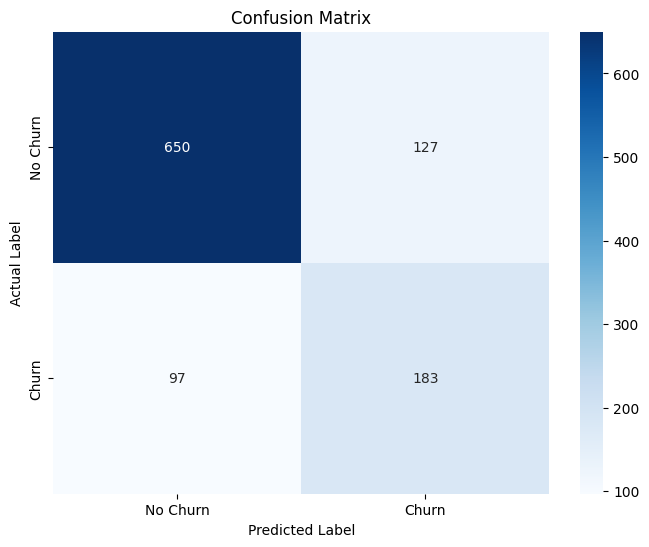

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

2. Confusion Matrix Heatmap
This is like a special scoreboard for our guessing game! Imagine our machine is trying to guess if a customer will leave (Churn) or stay (No Churn).

Top-Left (Blue, 650): Our machine guessed "Stay!" and the customer actually stayed! Yay! That's a correct guess.
Top-Right (Lighter Blue, 127): Our machine guessed "Stay!" but the customer actually left. Oh no! That's a wrong guess.
Bottom-Left (Lighter Blue, 97): Our machine guessed "Leave!" but the customer actually stayed. Oops! Another wrong guess.
Bottom-Right (Blue, 183): Our machine guessed "Leave!" and the customer actually left! Hooray! Another correct guess.
The goal is to have big, dark blue numbers in the corners (top-left and bottom-right) and small, light numbers in the other two spots. It means our machine is good at guessing!

### ROC Curve and AUC

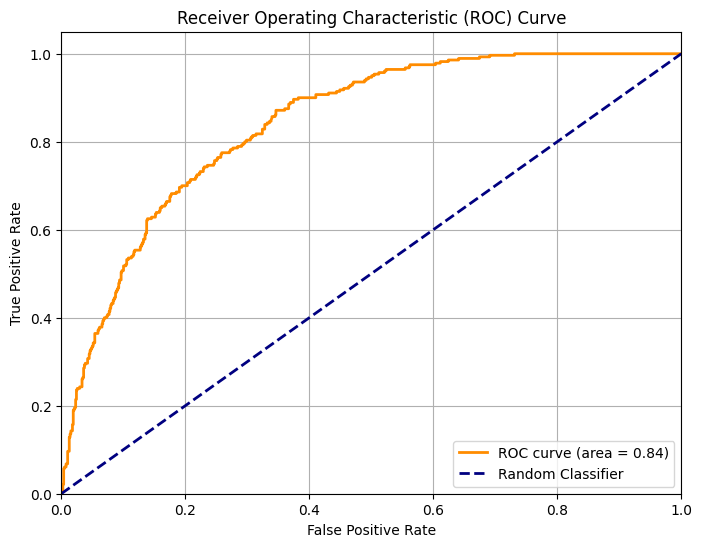

In [53]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

3. ROC Curve and AUC
This one is a bit like a "super-tester" for our guessing machine. Imagine you have a magic flashlight that can help you find all the hidden treasures (customers who will churn).

The red line (our machine's magic flashlight) shows how good our machine is at finding all the treasures (True Positives) without accidentally pointing at too many regular rocks (False Positives).
The blue dashed line is like if you just closed your eyes and pointed randomly. You'd find some treasures, but you'd also point at a lot of rocks!
We want our red line to hug the top-left corner as much as possible. The closer it is to that corner, the better our machine's magic flashlight is! The area = 0.84 (AUC) is like how big a treasure map our magic flashlight covers – the closer to 1, the better it is at finding all the hidden treasures.

# 9. Guardamos modelo

In [49]:
model.save("../models/churn_model.h5")

In [50]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")

['preprocessor.joblib']